In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set plot style
sns.set(style="whitegrid")

In [49]:
# Load the dataset
file_path = "/Users/areebhasan/Documents/Data Science/Quantium-Retail-Data-Analytics-and-Strategy/"  # Update this path based on your file location
data = pd.read_csv(f"{file_path}QVI_data.csv")

# Display the first few rows of the dataset
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [78]:
def calculate_metrics(data):
    """
    Calculate the required metrics over time for each store.
    Returns a DataFrame with metrics.
    """
    metrics = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', 'nunique'),
        nTxnPerCust=('TXN_ID', 'size'),  # Number of transactions (size of the group)
        nChipsPerTxn=('PROD_QTY', 'sum'),  # Total quantity of chips sold
        avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())  # Avg price per unit
    ).reset_index()

    metrics['avgPricePerUnit'] = metrics['totSales'] / metrics['nChipsPerTxn']

    return metrics

# Calculate the metrics
metrics = calculate_metrics(data)
metrics.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,3.337097
1,1,2018-08,176.1,42,43,54,3.261111
2,1,2018-09,278.8,59,62,75,3.717333
3,1,2018-10,188.1,44,45,58,3.243103
4,1,2018-11,192.6,46,47,57,3.378947


In [80]:
def filter_pre_trial_data(metrics, pre_trial_end='201902'):
    """
    Filters the data to include only stores with full observation periods before the trial.
    Returns a DataFrame with pre-trial data.
    """
    stores_with_full_obs = metrics.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()
    pre_trial_data = metrics[(metrics['YEARMONTH'] < pre_trial_end) & 
                             (metrics['STORE_NBR'].isin(stores_with_full_obs))]
    return pre_trial_data

# Filter the pre-trial data
pre_trial_metrics = filter_pre_trial_data(metrics)
print("Pre-trial data filtered successfully. Here are the first few rows:")
pre_trial_metrics.head()

Pre-trial data filtered successfully. Here are the first few rows:


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,3.337097
1,1,2018-08,176.1,42,43,54,3.261111
2,1,2018-09,278.8,59,62,75,3.717333
3,1,2018-10,188.1,44,45,58,3.243103
4,1,2018-11,192.6,46,47,57,3.378947


In [88]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """
    Calculate the correlation between the trial store and potential control stores.
    Returns a DataFrame with correlations.
    """
    store_numbers = input_table['STORE_NBR'].unique()
    corr_list = []

    for store in store_numbers:
        if store != store_comparison:
            store_data = input_table[input_table['STORE_NBR'] == store][['YEARMONTH', metric_col]]
            comparison_data = input_table[input_table['STORE_NBR'] == store_comparison][['YEARMONTH', metric_col]]
            
            # Merge on YEARMONTH to ensure alignment
            merged_data = pd.merge(store_data, comparison_data, on='YEARMONTH', suffixes=('_store', '_comparison'))
            
            # Calculate correlation only if there is sufficient data
            if len(merged_data) > 1:  # Ensure there's enough data to calculate correlation
                corr_measure = merged_data[f'{metric_col}_store'].corr(merged_data[f'{metric_col}_comparison'])
            else:
                corr_measure = np.nan  # Not enough data to calculate correlation

            corr_list.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': corr_measure})
    
    # Convert list to DataFrame
    corr_table = pd.DataFrame(corr_list)
    
    return corr_table

# Example usage for store 77
trial_store = 77
corr_nSales = calculate_correlation(pre_trial_metrics, 'totSales', trial_store)
print(f"Correlation calculation completed for trial store {trial_store}. Here are the results:")
corr_nSales.head()

Correlation calculation completed for trial store 77. Here are the results:


,Store1,Store2,corr_measure
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652


In [92]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate a standardized magnitude distance for a metric between trial and potential control stores.
    Returns a DataFrame with magnitude distances.
    """
    store_numbers = input_table['STORE_NBR'].unique()
    dist_list = []

    for store in store_numbers:
        if store != store_comparison:
            store_data = input_table[input_table['STORE_NBR'] == store][['YEARMONTH', metric_col]]
            comparison_data = input_table[input_table['STORE_NBR'] == store_comparison][['YEARMONTH', metric_col]]
            
            # Merge to align on YEARMONTH
            merged_data = pd.merge(store_data, comparison_data, on='YEARMONTH', suffixes=('_store', '_comparison'))
            
            # Calculate the magnitude distance
            measure = abs(merged_data[f'{metric_col}_store'] - merged_data[f'{metric_col}_comparison'])
            
            # Append results to the list
            dist_list.append(pd.DataFrame({
                'Store1': store_comparison, 
                'Store2': store, 
                'YEARMONTH': merged_data['YEARMONTH'], 
                'measure': measure
            }))
    
    # Concatenate the list into a single DataFrame
    dist_table = pd.concat(dist_list, ignore_index=True)
    
    # Standardizing the magnitude distance
    min_max_dist = dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['min']) / (dist_table['max'] - dist_table['min'])
    
    # Average magnitude measure over all months for each store pair
    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    
    return final_dist_table

# Example usage for store 77
trial_store = 77
magnitude_nSales = calculate_magnitude_distance(pre_trial_metrics, 'totSales', trial_store)
print(f"Magnitude distance calculation completed for trial store {trial_store}. Here are the results:")
magnitude_nSales.head()

Magnitude distance calculation completed for trial store 77. Here are the results:


,Store1,Store2,magnitudeMeasure
0,77,1,0.955061
1,77,2,0.939318
2,77,3,0.354963
3,77,4,0.177414
4,77,5,0.554066


In [96]:
def combine_scores_and_select_control(corr_nSales, magnitude_nSales, corr_nCustomers, magnitude_nCustomers, trial_store, sales_weight=0.5, customer_weight=0.5):
    """
    Combine correlation and magnitude scores to determine the control store.
    Returns the store number of the selected control store.
    """
    # Combine sales scores
    score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], suffixes=('_corr', '_mag'))
    score_nSales['scoreNSales'] = sales_weight * score_nSales['corr_measure'] + (1 - sales_weight) * score_nSales['magnitudeMeasure']

    # Combine customer scores
    score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], suffixes=('_corr', '_mag'))
    score_nCustomers['scoreNCust'] = customer_weight * score_nCustomers['corr_measure'] + (1 - customer_weight) * score_nCustomers['magnitudeMeasure']

    # Combine sales and customer scores into final control score
    score_Control = pd.merge(score_nSales[['Store2', 'scoreNSales']], score_nCustomers[['Store2', 'scoreNCust']], on='Store2')
    score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

    # Exclude the trial store and select the store with the highest final control score
    score_Control = score_Control[score_Control['Store2'] != trial_store]
    control_store = score_Control.sort_values('finalControlScore', ascending=False).iloc[0]['Store2']
    
    return control_store

# Calculate the correlation and magnitude for customers
corr_nCustomers = calculate_correlation(pre_trial_metrics, 'nCustomers', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_metrics, 'nCustomers', trial_store)

# Select the control store
control_store = combine_scores_and_select_control(corr_nSales, magnitude_nSales, corr_nCustomers, magnitude_nCustomers, trial_store)
print(f"Control store selected for trial store {trial_store}: {control_store}")

Control store selected for trial store 77: 233.0


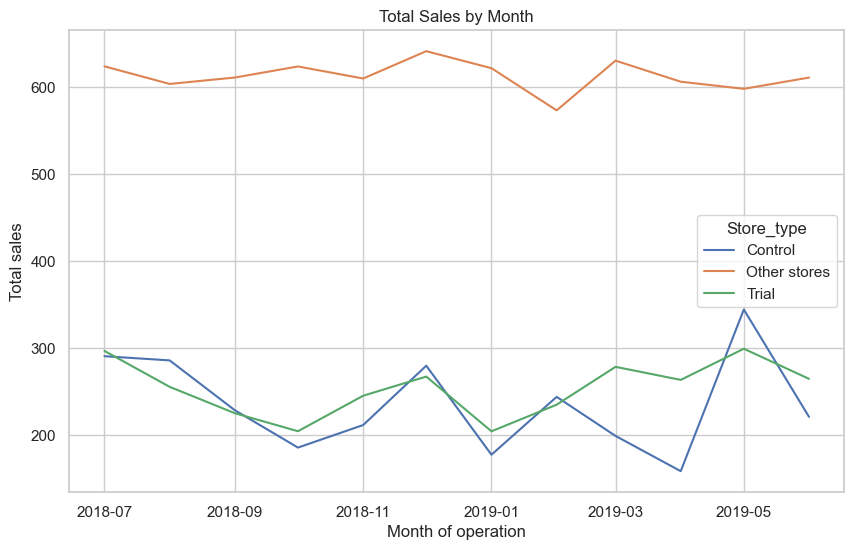

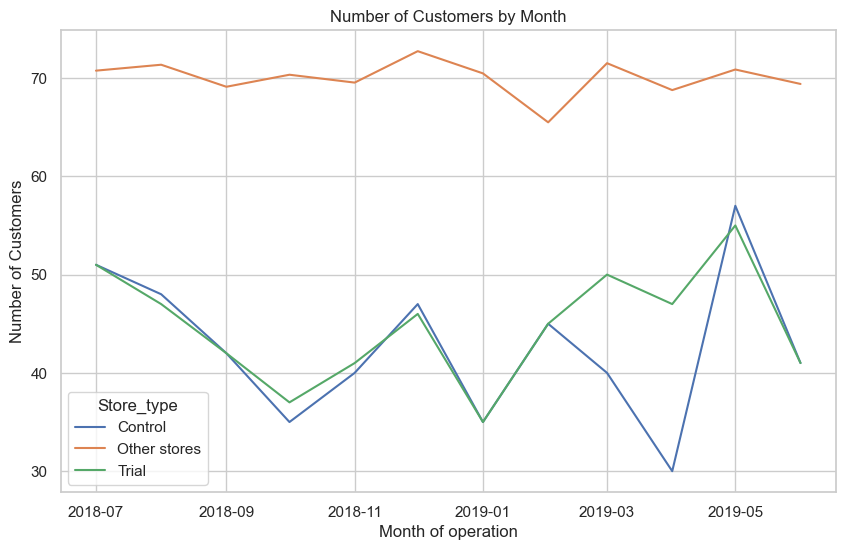

In [102]:
def visualize_trends(metrics, trial_store, control_store):
    """
    Visualize the trends of total sales and number of customers for the trial store, control store, and others.
    """
    metrics['Store_type'] = np.where(metrics['STORE_NBR'] == trial_store, 'Trial', 
                                     np.where(metrics['STORE_NBR'] == control_store, 'Control', 'Other stores'))

    # Visualizing total sales
    sales_data = metrics.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
    sales_data['TransactionMonth'] = sales_data['YEARMONTH'].dt.to_timestamp()

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=sales_data)
    plt.title('Total Sales by Month')
    plt.xlabel('Month of operation')
    plt.ylabel('Total sales')
    plt.show()

    # Visualizing number of customers
    customers_data = metrics.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
    customers_data['TransactionMonth'] = customers_data['YEARMONTH'].dt.to_timestamp()

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='TransactionMonth', y='nCustomers', hue='Store_type', data=customers_data)
    plt.title('Number of Customers by Month')
    plt.xlabel('Month of operation')
    plt.ylabel('Number of Customers')
    plt.show()

# Visualize the trends for store 77
visualize_trends(metrics, trial_store, control_store)

In [112]:
def assess_trial_impact(metrics, trial_store, control_store, pre_trial_end='201902', trial_start='201902', trial_end='201904'):
    """
    Scale control store sales to match trial store sales and assess the trial impact.
    Returns a DataFrame with percentage differences and t-values.
    """
    # Calculate the scaling factor based on pre-trial sales
    trial_pre_sales = metrics[(metrics['STORE_NBR'] == trial_store) & (metrics['YEARMONTH'] < pre_trial_end)]['totSales'].sum()
    control_pre_sales = metrics[(metrics['STORE_NBR'] == control_store) & (metrics['YEARMONTH'] < pre_trial_end)]['totSales'].sum()

    if control_pre_sales == 0:
        raise ValueError("Control store pre-trial sales are zero, cannot scale.")

    scaling_factor = trial_pre_sales / control_pre_sales

    # Apply the scaling factor to control store sales
    scaled_control_sales = metrics[metrics['STORE_NBR'] == control_store].copy()
    scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor

    # Calculate the percentage difference between scaled control and trial sales
    percentage_diff = pd.merge(scaled_control_sales[['YEARMONTH', 'controlSales']], 
                               metrics[metrics['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']], 
                               on='YEARMONTH')
    percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

    # Calculate standard deviation of percentage differences in the pre-trial period
    pre_trial_diff = percentage_diff[percentage_diff['YEARMONTH'] < pre_trial_end]
    if len(pre_trial_diff) < 2:
        raise ValueError("Not enough pre-trial data to calculate standard deviation.")

    std_dev = pre_trial_diff['percentageDiff'].std()

    # Calculate degrees of freedom dynamically
    degrees_of_freedom = len(pre_trial_diff) - 1

    # Calculate t-values for the trial period
    percentage_diff['tValue'] = (percentage_diff['percentageDiff'] - 0) / std_dev

    return percentage_diff, std_dev

# Assess the trial impact for store 77
percentage_diff, std_dev = assess_trial_impact(metrics, trial_store, control_store)
print("Trial impact assessment complete. Here are the results:")
percentage_diff.head()

Trial impact assessment complete. Here are the results:


,YEARMONTH,controlSales,totSales,percentageDiff,tValue
0,2018-07,297.565550,296.8,0.002573,0.051515
1,2018-08,292.652187,255.5,0.126950,2.542011
2,2018-09,233.998916,225.2,0.037602,0.752940
3,2018-10,190.085733,204.5,0.075830,1.518406
4,2018-11,216.597421,245.3,0.132516,2.653459


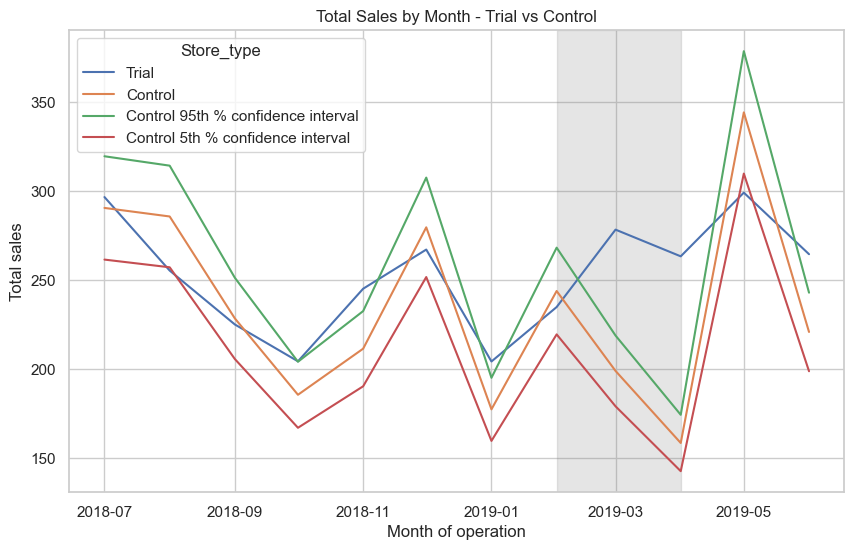

In [118]:
def visualize_trial_assessment(metrics, percentage_diff, std_dev, trial_store, control_store, trial_start='201902', trial_end='201904'):
    """
    Visualize the trial assessment with control store confidence intervals.
    """
    # Identify store types
    metrics['Store_type'] = np.where(metrics['STORE_NBR'] == trial_store, 'Trial', 
                                     np.where(metrics['STORE_NBR'] == control_store, 'Control', 'Other stores'))
    past_sales = metrics[metrics['Store_type'].isin(['Trial', 'Control'])].copy()
    
    # Convert YEARMONTH to a proper datetime object representing the first day of the month
    past_sales['TransactionMonth'] = past_sales['YEARMONTH'].dt.to_timestamp()

    # 95th and 5th percentile confidence intervals
    past_sales_controls_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
    past_sales_controls_95['totSales'] *= (1 + std_dev * 2)
    past_sales_controls_95['Store_type'] = 'Control 95th % confidence interval'

    past_sales_controls_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
    past_sales_controls_5['totSales'] *= (1 - std_dev * 2)
    past_sales_controls_5['Store_type'] = 'Control 5th % confidence interval'

    # Combine all the data for plotting
    trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=trial_assessment)
    plt.axvspan(pd.to_datetime(trial_start + '01'), pd.to_datetime(trial_end + '01'), color='grey', alpha=0.2)
    plt.title('Total Sales by Month - Trial vs Control')
    plt.xlabel('Month of operation')
    plt.ylabel('Total sales')
    plt.show()

# Visualize the trial assessment for store 77
visualize_trial_assessment(metrics, percentage_diff, std_dev, trial_store, control_store)

In [120]:
from scipy.stats import ttest_ind

def perform_hypothesis_test(percentage_diff, trial_start='201902', trial_end='201904'):
    """
    Perform a t-test to compare the sales during the trial period.
    Returns the t-statistic, p-value, and conclusion.
    """
    trial_period = percentage_diff[(percentage_diff['YEARMONTH'] >= trial_start) & 
                                   (percentage_diff['YEARMONTH'] <= trial_end)]
    
    # Null hypothesis: The means of the two groups are equal
    t_stat, p_value = ttest_ind(trial_period['totSales'], trial_period['controlSales'], equal_var=False)
    
    # Check if we can reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        conclusion = "Reject the null hypothesis: There is a significant difference in sales during the trial period."
    else:
        conclusion = "Fail to reject the null hypothesis: No significant difference in sales during the trial period."
    
    return t_stat, p_value, conclusion

# Perform hypothesis test for store 77
t_stat, p_value, conclusion = perform_hypothesis_test(percentage_diff)
print(f"Hypothesis Test Results for Store 77:\nT-Statistic: {t_stat}\nP-Value: {p_value}\nConclusion: {conclusion}")

Hypothesis Test Results for Store 77:
T-Statistic: 1.8983113451123734
P-Value: 0.15516491244377667
Conclusion: Fail to reject the null hypothesis: No significant difference in sales during the trial period.


In [122]:

def calculate_confidence_interval(percentage_diff, std_dev, trial_start='201902', trial_end='201904', confidence_level=0.95):
    """
    Calculate the confidence interval for the difference in sales during the trial period.
    Returns the confidence interval (lower, upper).
    """
    trial_period = percentage_diff[(percentage_diff['YEARMONTH'] >= trial_start) & 
                                   (percentage_diff['YEARMONTH'] <= trial_end)]
    
    mean_diff = trial_period['percentageDiff'].mean()
    n = len(trial_period)
    se = std_dev / np.sqrt(n)
    
    # Calculate the margin of error
    margin_of_error = t.ppf((1 + confidence_level) / 2, df=n-1) * se
    
    # Calculate the confidence interval
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error
    
    return ci_lower, ci_upper

# Calculate confidence interval for store 77
ci_lower, ci_upper = calculate_confidence_interval(percentage_diff, std_dev)
print(f"Confidence Interval for Store 77 (95%): Lower = {ci_lower}, Upper = {ci_upper}")

Confidence Interval for Store 77 (95%): Lower = 0.22550934797074318, Upper = 0.47362881162994197


In [124]:
def calculate_cohens_d(percentage_diff, trial_start='201902', trial_end='201904'):
    """
    Calculate Cohen's d for the difference in sales between the trial and control stores.
    Returns Cohen's d value.
    """
    trial_period = percentage_diff[(percentage_diff['YEARMONTH'] >= trial_start) & 
                                   (percentage_diff['YEARMONTH'] <= trial_end)]
    
    # Calculate the means and standard deviations of the two groups
    mean_diff = trial_period['percentageDiff'].mean()
    pooled_std = np.sqrt(((trial_period['totSales'].std() ** 2) + 
                          (trial_period['controlSales'].std() ** 2)) / 2)
    
    # Calculate Cohen's d
    cohens_d = mean_diff / pooled_std
    
    return cohens_d

# Calculate Cohen's d for store 77
cohens_d = calculate_cohens_d(percentage_diff)
print(f"Cohen's d for Store 77: {cohens_d}")

Cohen's d for Store 77: 0.010090412735587174


In [126]:
def comprehensive_summary(percentage_diff, std_dev, trial_store, control_store, trial_start='201902', trial_end='201904'):
    """
    Compile a comprehensive summary of the statistical readings for the trial.
    """
    t_stat, p_value, hypothesis_conclusion = perform_hypothesis_test(percentage_diff, trial_start, trial_end)
    ci_lower, ci_upper = calculate_confidence_interval(percentage_diff, std_dev, trial_start, trial_end)
    cohens_d = calculate_cohens_d(percentage_diff, trial_start, trial_end)
    
    print(f"Comprehensive Summary for Trial Store {trial_store} (Control Store: {control_store})")
    print("-" * 60)
    print(f"Hypothesis Test:")
    print(f"  T-Statistic: {t_stat:.4f}")
    print(f"  P-Value: {p_value:.4f}")
    print(f"  Conclusion: {hypothesis_conclusion}")
    print(f"\nConfidence Interval (95%):")
    print(f"  Lower Bound: {ci_lower:.4f}")
    print(f"  Upper Bound: {ci_upper:.4f}")
    print(f"\nEffect Size (Cohen's d):")
    print(f"  Cohen's d: {cohens_d:.4f}")
    print("-" * 60)
    print("\nInterpretation:")
    if p_value < 0.05:
        print(f"The results suggest that the sales in trial store {trial_store} were significantly different from the control store during the trial period.")
        print(f"The effect size (Cohen's d) indicates that this difference is {'small' if cohens_d < 0.5 else 'medium' if cohens_d < 0.8 else 'large'}.")
    else:
        print(f"The results suggest that there was no significant difference in sales between the trial store {trial_store} and the control store during the trial period.")
        print("Further investigation may be needed to determine the causes of this lack of significance.")

# Generate the summary for store 77
comprehensive_summary(percentage_diff, std_dev, trial_store, control_store)

Comprehensive Summary for Trial Store 77 (Control Store: 233.0)
------------------------------------------------------------
Hypothesis Test:
  T-Statistic: 1.8983
  P-Value: 0.1552
  Conclusion: Fail to reject the null hypothesis: No significant difference in sales during the trial period.

Confidence Interval (95%):
  Lower Bound: 0.2255
  Upper Bound: 0.4736

Effect Size (Cohen's d):
  Cohen's d: 0.0101
------------------------------------------------------------

Interpretation:
The results suggest that there was no significant difference in sales between the trial store 77 and the control store during the trial period.
Further investigation may be needed to determine the causes of this lack of significance.


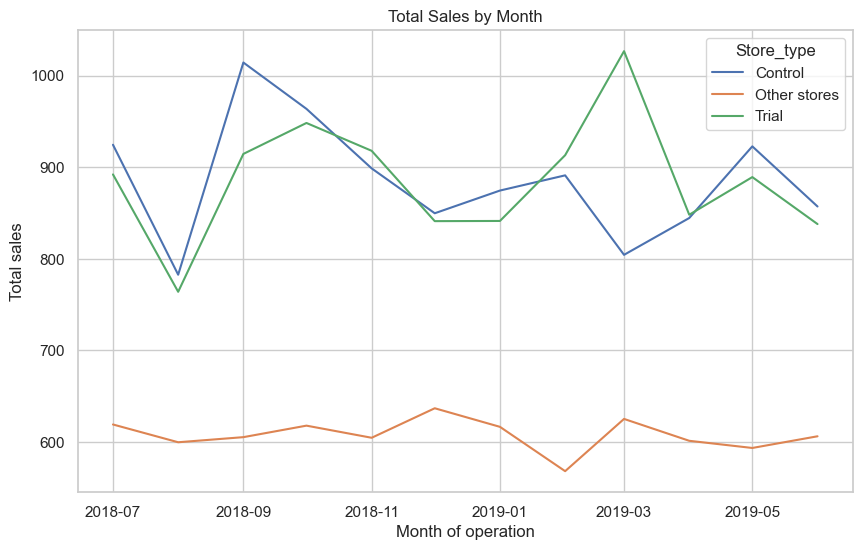

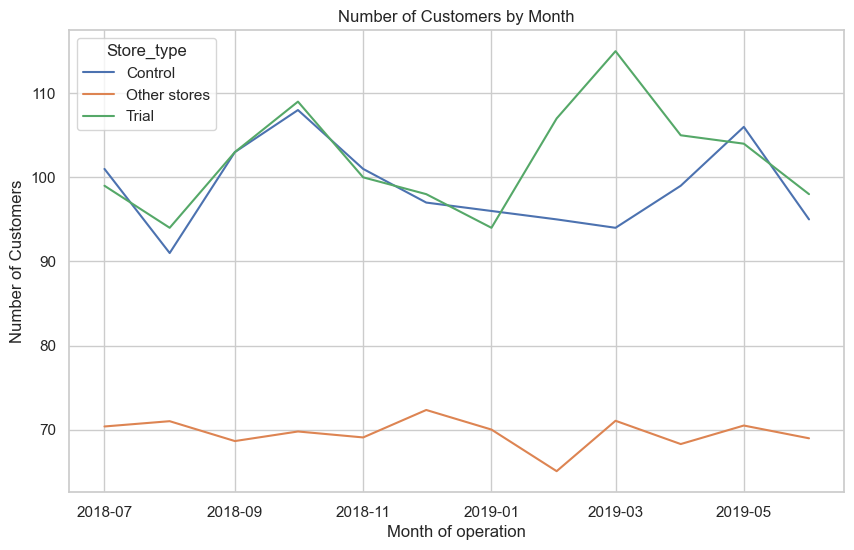

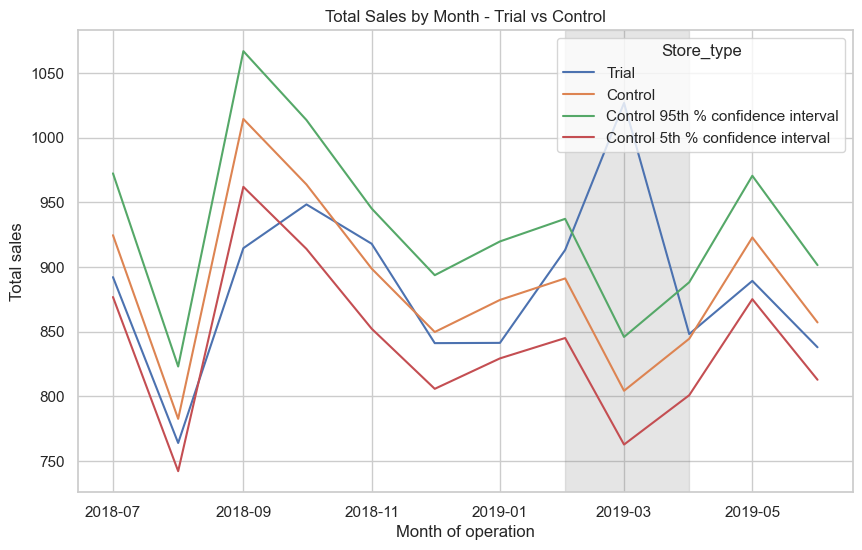

Comprehensive Summary for Trial Store 86 (Control Store: 155.0)
------------------------------------------------------------
Hypothesis Test:
  T-Statistic: 1.8758
  P-Value: 0.1628
  Conclusion: Fail to reject the null hypothesis: No significant difference in sales during the trial period.

Confidence Interval (95%):
  Lower Bound: 0.0716
  Upper Bound: 0.2000

Effect Size (Cohen's d):
  Cohen's d: 0.0019
------------------------------------------------------------

Interpretation:
The results suggest that there was no significant difference in sales between the trial store 86 and the control store during the trial period.
Further investigation may be needed to determine the causes of this lack of significance.


In [130]:
# For store 86:
trial_store = 86
corr_nSales = calculate_correlation(pre_trial_metrics, 'totSales', trial_store)
magnitude_nSales = calculate_magnitude_distance(pre_trial_metrics, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_metrics, 'nCustomers', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_metrics, 'nCustomers', trial_store)

# Pass the trial_store as an argument to the function
control_store = combine_scores_and_select_control(corr_nSales, magnitude_nSales, corr_nCustomers, magnitude_nCustomers, trial_store)

# Visualize trends and assess the impact
visualize_trends(metrics, trial_store, control_store)
percentage_diff, std_dev = assess_trial_impact(metrics, trial_store, control_store)
visualize_trial_assessment(metrics, percentage_diff, std_dev, trial_store, control_store)
comprehensive_summary(percentage_diff, std_dev, trial_store, control_store)

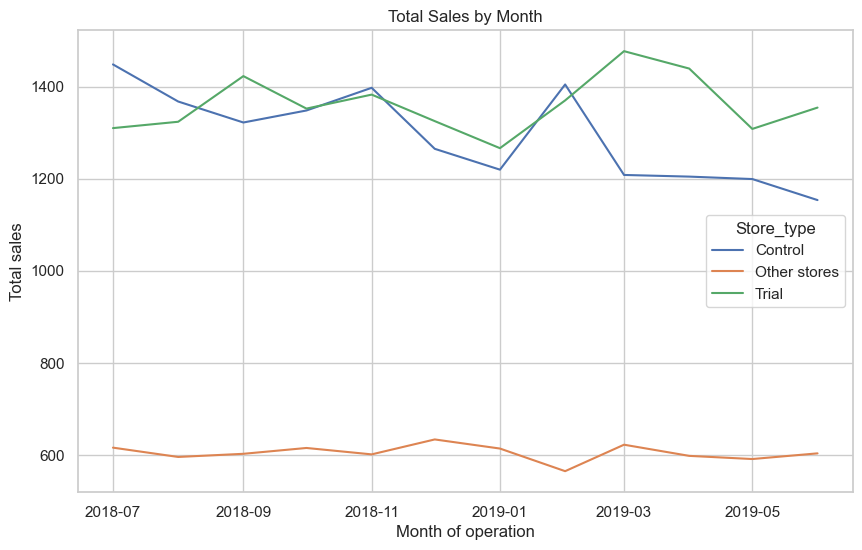

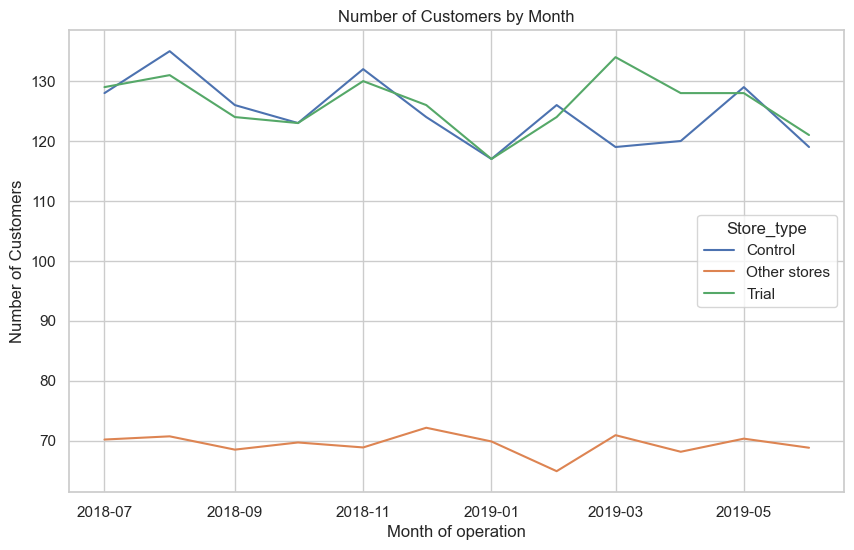

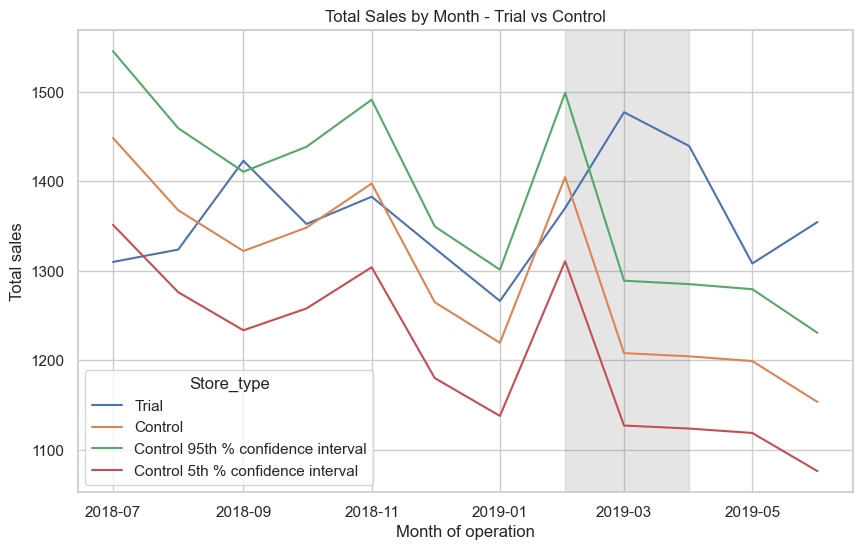

Comprehensive Summary for Trial Store 88 (Control Store: 237.0)
------------------------------------------------------------
Hypothesis Test:
  T-Statistic: 2.1072
  P-Value: 0.1304
  Conclusion: Fail to reject the null hypothesis: No significant difference in sales during the trial period.

Confidence Interval (95%):
  Lower Bound: 0.0635
  Upper Bound: 0.2298

Effect Size (Cohen's d):
  Cohen's d: 0.0016
------------------------------------------------------------

Interpretation:
The results suggest that there was no significant difference in sales between the trial store 88 and the control store during the trial period.
Further investigation may be needed to determine the causes of this lack of significance.


In [132]:
# For store 88:
trial_store = 88
corr_nSales = calculate_correlation(pre_trial_metrics, 'totSales', trial_store)
magnitude_nSales = calculate_magnitude_distance(pre_trial_metrics, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_metrics, 'nCustomers', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_metrics, 'nCustomers', trial_store)

# Pass the trial_store as an argument to the function
control_store = combine_scores_and_select_control(corr_nSales, magnitude_nSales, corr_nCustomers, magnitude_nCustomers, trial_store)

# Visualize trends and assess the impact
visualize_trends(metrics, trial_store, control_store)
percentage_diff, std_dev = assess_trial_impact(metrics, trial_store, control_store)
visualize_trial_assessment(metrics, percentage_diff, std_dev, trial_store, control_store)
comprehensive_summary(percentage_diff, std_dev, trial_store, control_store)